# %% [Load Libraries]

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import numpy as np 
import pandas as pd 
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from patsy import dmatrices
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn import svm
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
%pip install lime
import lime
from lime.lime_tabular import LimeTabularExplainer

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_digits
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print("The output is:" + color.YELLOW + 'Python 3!')

The output is:Python 3!


# %% [SECTION_1 Load Files]

In [44]:
df=pd.read_csv("/content/drive/MyDrive/alzheimer.csv")
df.head()

,Group,M/F,Age,EDUC (Years of education),SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [45]:
df = df.rename(columns = {'M/F' : 'Gender' })
df = df.rename(columns = {'EDUC (Years of education)' : 'EDUC' })
df.columns
df.isnull().sum()

Group      0
Gender     0
Age        0
EDUC       0
SES       19
MMSE       2
CDR        0
eTIV       0
nWBV       0
ASF        0
dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Group   373 non-null    object 
 1   Gender  373 non-null    object 
 2   Age     373 non-null    int64  
 3   EDUC    373 non-null    int64  
 4   SES     354 non-null    float64
 5   MMSE    371 non-null    float64
 6   CDR     373 non-null    float64
 7   eTIV    373 non-null    int64  
 8   nWBV    373 non-null    float64
 9   ASF     373 non-null    float64
dtypes: float64(5), int64(3), object(2)
memory usage: 29.3+ KB


In [47]:
df.isnull().sum()

Group      0
Gender     0
Age        0
EDUC       0
SES       19
MMSE       2
CDR        0
eTIV       0
nWBV       0
ASF        0
dtype: int64

In [48]:
df['Group'].value_counts()

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

In [49]:
df.isnull().mean()

Group     0.000000
Gender    0.000000
Age       0.000000
EDUC      0.000000
SES       0.050938
MMSE      0.005362
CDR       0.000000
eTIV      0.000000
nWBV      0.000000
ASF       0.000000
dtype: float64

In [50]:
#One hot encoding (Group and Gender have nominal categorical data)
df['Group'] = df['Group'].apply(lambda x : 1 if x == 'Demented' else 0)
df['Gender'] = df['Gender'].apply(lambda x : 1 if x == 'M' else 0)
df=df.drop(df[df["Group"]=="Converted"].index)

In [51]:
df.std()

Group       0.488724
Gender      0.495592
Age         7.640957
EDUC        2.876339
SES         1.134005
MMSE        3.683244
CDR         0.374557
eTIV      176.139286
nWBV        0.037135
ASF         0.138092
dtype: float64

In [52]:
df['SES'] = df['SES'].fillna(df['SES'].median())
df['MMSE'] = df['MMSE'].fillna(df['MMSE'].mean())

In [53]:
df.isnull().sum()

Group     0
Gender    0
Age       0
EDUC      0
SES       0
MMSE      0
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

In [54]:
df.groupby('Group').mean()

,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Group,,,,,,,,,
0,0.325991,77.497797,15.193833,2.286344,29.136564,0.046256,1489.594714,0.738101,1.194542
1,0.589041,76.260274,13.671233,2.671233,24.552634,0.671233,1485.849315,0.716301,1.196890


# %% [SECTION_2 Correlation Multicolinearity]

In [55]:
#https://www.youtube.com/watch?v=FndwYNcVe0U
#Coorelation
X = df.iloc[:, 1:10]
y = df.iloc[:, 1]
X.head()

,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,1,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,1,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,1,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [56]:
# train test split to prevent overfitting part
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
corrMatrix = X_train.corr()
corrMatrix

,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Gender,1.000000,-0.057078,0.079938,-0.075417,-0.151134,0.177290,0.556862,-0.230506,-0.543566
Age,-0.057078,1.000000,-0.024833,-0.028582,0.035918,-0.000752,0.036978,-0.514603,-0.037997
EDUC,0.079938,-0.024833,1.000000,-0.703638,0.189396,-0.146171,0.274697,0.000147,-0.250276
SES,-0.075417,-0.028582,-0.703638,1.000000,-0.105739,0.030023,-0.310372,0.105989,0.292824
MMSE,-0.151134,0.035918,0.189396,-0.105739,1.000000,-0.680727,-0.059891,0.362692,0.066819
CDR,0.177290,-0.000752,-0.146171,0.030023,-0.680727,1.000000,0.054272,-0.363391,-0.054965
eTIV,0.556862,0.036978,0.274697,-0.310372,-0.059891,0.054272,1.000000,-0.232931,-0.989417
nWBV,-0.230506,-0.514603,0.000147,0.105989,0.362692,-0.363391,-0.232931,1.000000,0.239255
ASF,-0.543566,-0.037997,-0.250276,0.292824,0.066819,-0.054965,-0.989417,0.239255,1.000000


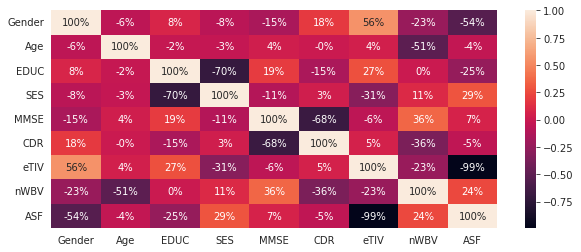

In [57]:
# pairwise correlation heatmap of the columns
#correlation = df.corr()
plt.figure(figsize=(10,4))
sns.heatmap(corrMatrix,annot=True, fmt=".0%")
plt.show()

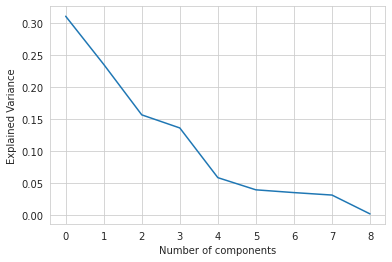

In [58]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Separate the features and target variable
X = df.drop("Group", axis=1)
y = df["Group"]

# Standardize the data to mean 0 and variance 1
X = (X - X.mean()) / X.std()

# Apply PCA to the standardized data
pca = PCA()
pca.fit(X)

# Transform the data using the fitted PCA model
X_pca = pca.transform(X)

# Plot the explained variance by each component
import matplotlib.pyplot as plt
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

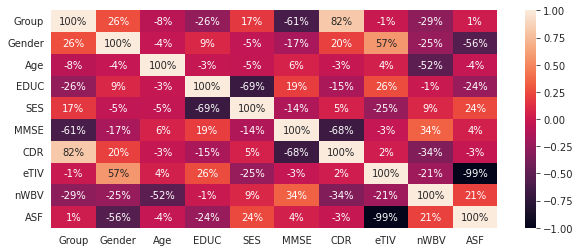

In [59]:
# pairwise correlation heatmap of the columns 
# dark -> correlation is in -ev 
# less dark -> correlation isaround  0 
# light -> correlation is very high
# How do you know if a variable is highly correlated?
# Complete correlation between two variables is expressed by either + 1 or -1. 
# When one variable increases as the other increases the correlation is positive;
#  when one decreases as the other increases it is negative. Complete absence of correlation is represented by 0.

correlation = df.corr()
plt.figure(figsize=(10,4))
sns.heatmap(correlation,annot=True,vmin=-1,fmt=".0%")
plt.show()

In [60]:
#Multico
# if we do not use abs then we are not getting negative corelated feature
def correlation (df, threshold):
    correlated_col = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            #   if abs(corr_matrix.iloc[i,j]) > threshold:
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                correlated_col.add(colname)
    return correlated_col

In [61]:
# at 0.6 threshhold so CDR is highly coorelated should i remove it? 0.4 meand these variables have 40% coorelation
corr_features = correlation(df, 0.9)
corr_features 

{'ASF'}

In [62]:
# drop the columns
# X_train.drop(corr_features,axis=1)
df.drop(corr_features,axis=1)

,Group,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV
0,0,1,87,14,2.0,27.0,0.0,1987,0.696
1,0,1,88,14,2.0,30.0,0.0,2004,0.681
2,1,1,75,12,2.0,23.0,0.5,1678,0.736
3,1,1,76,12,2.0,28.0,0.5,1738,0.713
4,1,1,80,12,2.0,22.0,0.5,1698,0.701
...,...,...,...,...,...,...,...,...,...
368,1,1,82,16,1.0,28.0,0.5,1693,0.694
369,1,1,86,16,1.0,26.0,0.5,1688,0.675
370,0,0,61,13,2.0,30.0,0.0,1319,0.801
371,0,0,63,13,2.0,30.0,0.0,1327,0.796


# %% [SECTION_3 Multivariate Analysis]

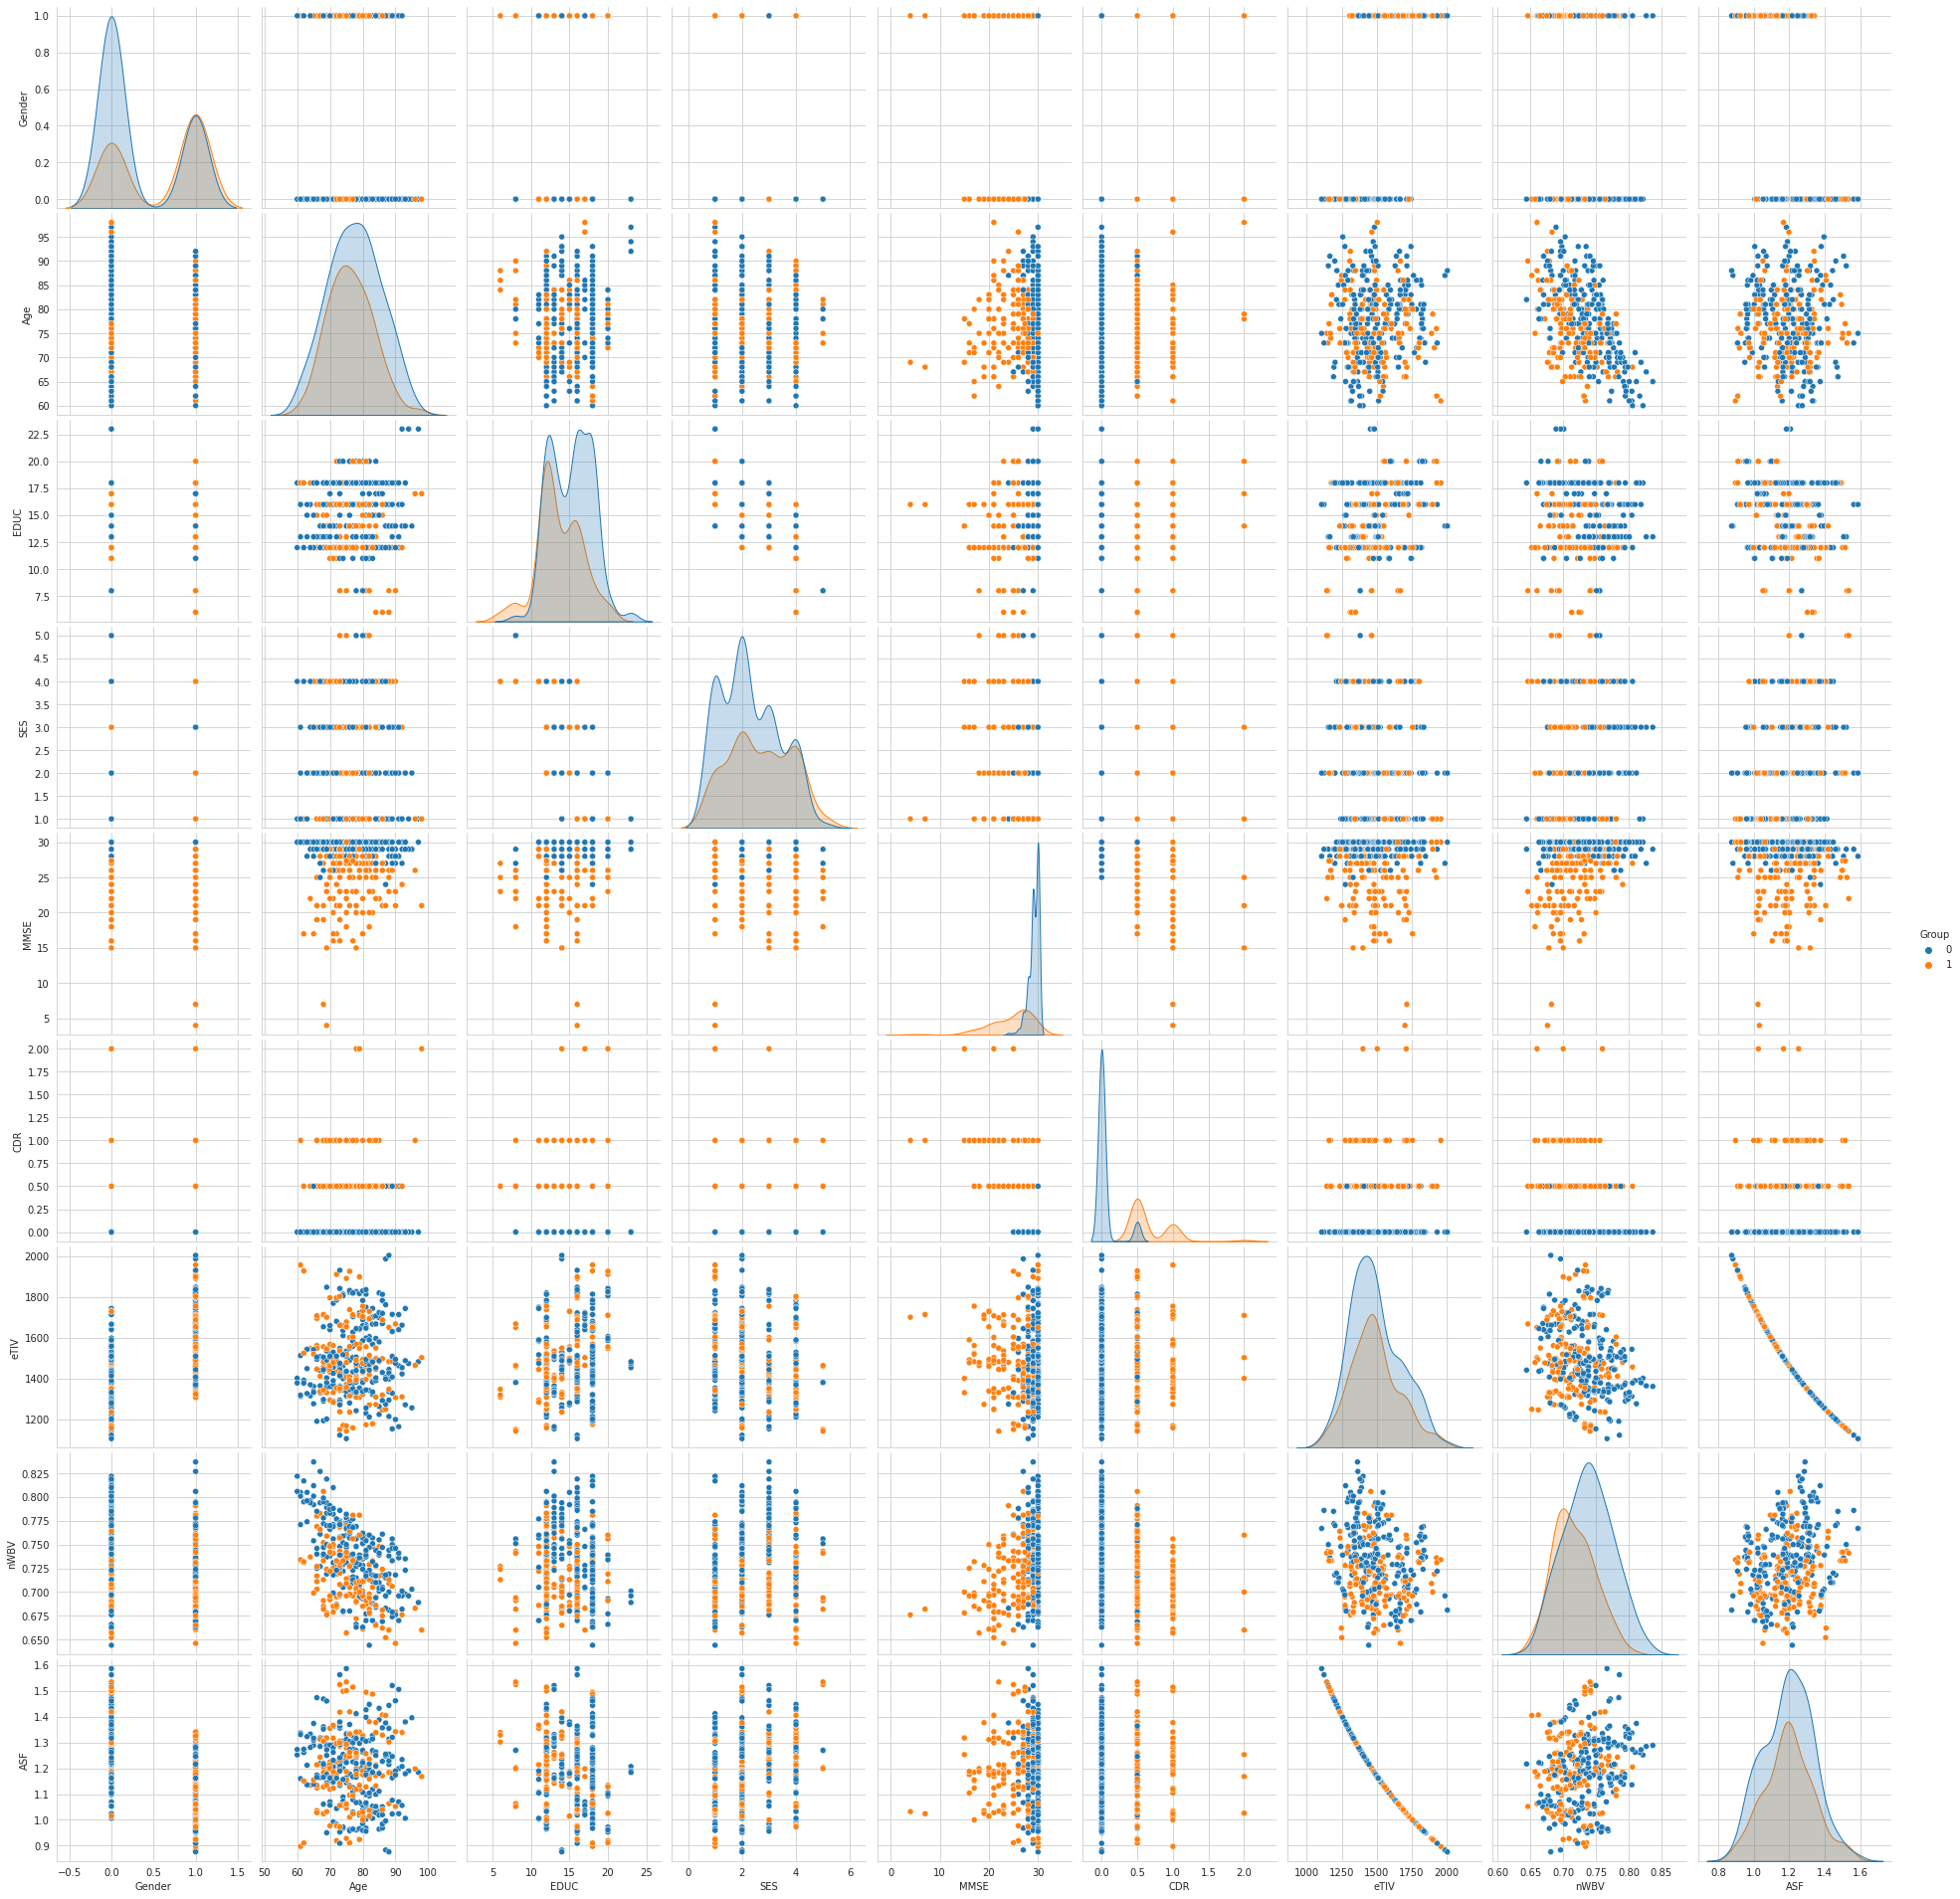

In [63]:
# distribution of target variable 
# Multivariate analysis
sns.set_style("whitegrid")
sns.pairplot(df,hue="Group",height=3)
plt.show()

# %% [SECTION_4 Outliers]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


iqr of  EDUC :  4.0
Upper limit EDUC :  22.0
Lower limit EDUC :  6.0
new_df  EDUC :       Group  Gender  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
107      0       0   92    23  1.0  29.0  0.0  1454  0.701  1.207
108      0       0   94    23  1.0  29.0  0.0  1474  0.696  1.190
109      0       0   97    23  1.0  30.0  0.0  1483  0.689  1.184 

iqr of  SES :  1.0
Upper limit SES :  4.5
Lower limit SES :  0.5
new_df  SES :       Group  Gender  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
136      1       0   78   8.0  5.0  23.0  1.0  1462  0.691  1.200
137      1       0   81   8.0  5.0  26.0  0.5  1459  0.694  1.203
138      1       0   82   8.0  5.0  18.0  0.5  1464  0.682  1.199
161      1       0   73   8.0  5.0  25.0  0.5  1151  0.743  1.525
162      1       0   75   8.0  5.0  22.0  0.5  1143  0.741  1.535
179      0       0   78   8.0  5.0  29.0  0.0  1383  0.756  1.269
180      0       0   80   8.0  5.0  27.0  0.0  1381  0.751  1.270 



/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

iqr of  MMSE :  3.0
Upper limit MMSE :  34.5
Lower limit MMSE :  22.5
new_df  MMSE :  Empty DataFrame
Columns: [Group, Gender, Age, EDUC, SES, MMSE, CDR, eTIV, nWBV, ASF]
Index: [] 



/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


iqr of  CDR :  0.5
Upper limit CDR :  1.25
Lower limit CDR :  -0.75
new_df  CDR :       Group  Gender  Age  EDUC  SES  MMSE  CDR  eTIV  nWBV    ASF
184      1       0   98  17.0  1.0  22.5  2.0  1503  0.66  1.168
251      1       0   78  14.0  3.0  22.5  2.0  1401  0.70  1.253
330      1       1   79  20.0  1.0  25.0  2.0  1710  0.76  1.026 



/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


iqr of  eTIV :  240.0
Upper limit eTIV :  1957.0
Lower limit eTIV :  997.0
new_df  eTIV :     Group  Gender  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0      0       1   87  14.0  2.0  27.0  0.0  1987  0.696  0.883
1      0       1   88  14.0  2.0  30.0  0.0  2004  0.681  0.876 



/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


iqr of  nWBV :  0.05600000000000005
Upper limit nWBV :  0.8400000000000001
Lower limit nWBV :  0.6159999999999999
new_df  nWBV :  Empty DataFrame
Columns: [Group, Gender, Age, EDUC, SES, MMSE, CDR, eTIV, nWBV, ASF]
Index: [] 



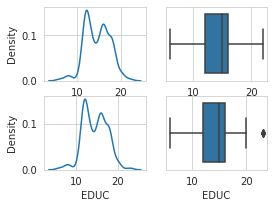

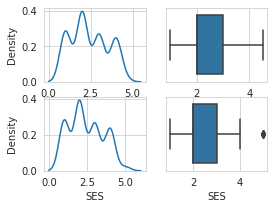

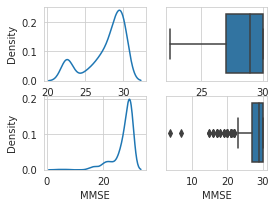

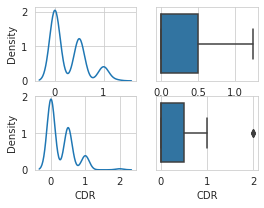

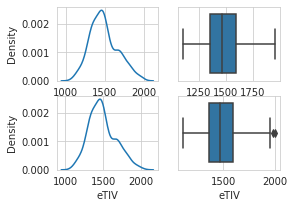

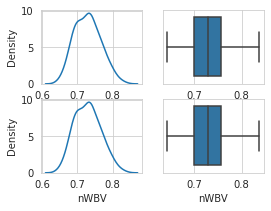

In [64]:
# Finding the IQR
outlier = ['EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV']
for i in (outlier):
    percentile25 = df[i].quantile(0.25)
    percentile75 = df[i].quantile(0.75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    df[df[i] < lower_limit]
    new_df = df[df[i] > upper_limit]
    # print('percentile75', percentile75 , '\n')
    # Comparing
    new_df_cap = df.copy()

    df[i] = np.where(
        df[i] > upper_limit,
        upper_limit,
        np.where(
            df[i] < lower_limit,
            lower_limit,
            df[i]
        )
    )
    # np.where(condtion,true,false)
    new_df_cap.shape
    # Comparing

    plt.figure(figsize=(4,3))
    plt.subplot(2,2,1)
    sns.kdeplot(df[i])

    plt.subplot(2,2,2)
    sns.boxplot(df[i])

    plt.subplot(2,2,3)
    sns.kdeplot(new_df_cap[i])

    plt.subplot(2,2,4)
    sns.boxplot(new_df_cap[i])


    print(color.YELLOW + "iqr of ", i, ": ",  iqr)
    print("Upper limit", i, ": " , upper_limit)
    print("Lower limit", i, ": " , lower_limit )
    print(color.GREEN + "new_df ", i, ": " , new_df , '\n')
    # print("The output is:" + color.YELLOW + 'Python 3!')


# %% [SECTION_6 Feature Distribution ]

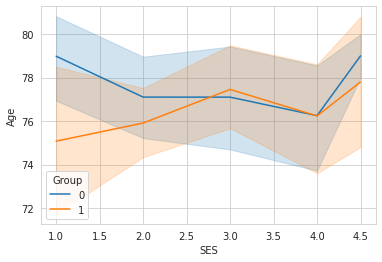

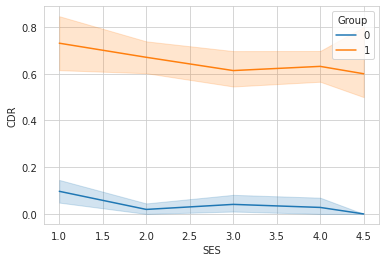

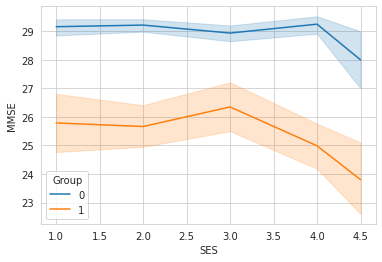

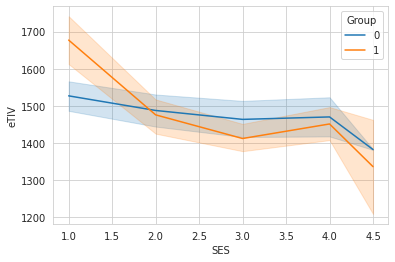

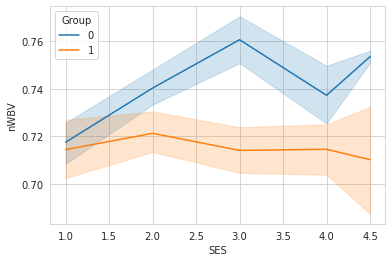

In [65]:
# num_features = ['MMSE', 'CDR', 'eTIV', 'nWBV', 'Age']
# fig, ax = plt.subplots(5, 1, figsize=(12,14))
# ax = ax.flatten()
# for i, col in enumerate(num_features):
#     # ax[i].set_aspect(1)
#     sns.histplot(data=df, x=col, hue='Group', stat='density', kde=True, ax=ax[i])
#     ax[i].set_title(f'Feature Distribution 1 = Demeneted / 0 = NonDemeneted: {col} vs Target')
# fig.tight_layout()
# fig.show()
sns.lineplot(x="SES", y='Age',hue="Group", data=df)
plt.show()
sns.lineplot(x="SES", y='CDR',hue="Group", data=df)
plt.show()
sns.lineplot(x="SES", y="MMSE",hue="Group", data=df)
plt.show()
sns.lineplot(x="SES", y="eTIV",hue="Group", data=df)
plt.show()
sns.lineplot(x="SES", y="nWBV",hue="Group", data=df)
plt.show()

In [66]:
#MMSE : Mini Mental State Examination
# Nondemented = 0, Demented =1
# Nondemented has higher test result ranging from 25 to 30. 
#Min 17 ,MAX 30

# facet= sns.FacetGrid(df,hue="Group", aspect=3)
# facet.map(sns.kdeplot,'MMSE',shade= True)
# facet.set(xlim=(0, df['MMSE'].max()))
# facet.add_legend()
# plt.xlim(15.30)

# sns.displot(x='MMSE', hue='Group', fill=True, data=df, kind="kde", aspect=3 )

<AxesSubplot:xlabel='MMSE', ylabel='Age'>

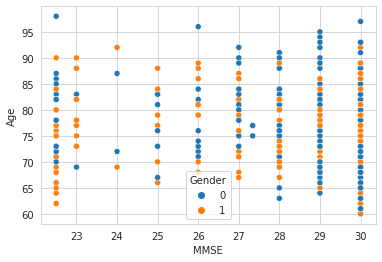

In [67]:
sns.scatterplot(x='MMSE', y='Age', data=df, hue='Gender')

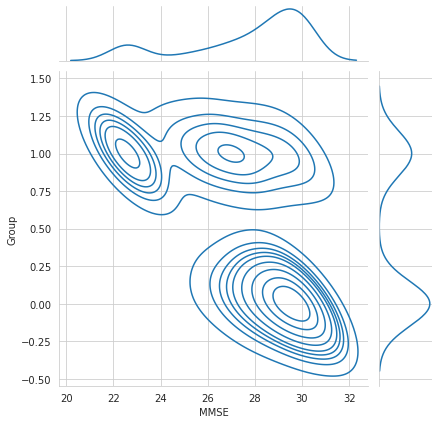

In [68]:
sns.jointplot(x='MMSE', y='Group', data=df, palette="YlGnBu", kind="kde" )

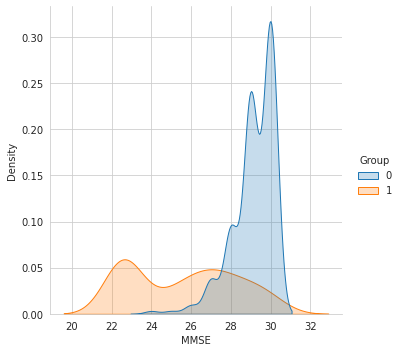

In [69]:
sns.displot(x='MMSE', hue='Group', fill=True, data=df, kind="kde" )

<AxesSubplot:xlabel='MMSE', ylabel='count'>

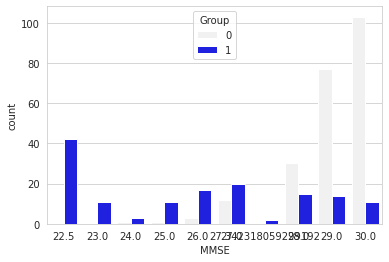

In [70]:
sns.countplot(x='MMSE', data=df, color='blue', hue='Group')

# %% [SECTION_7 MODALS ]

In [71]:
# classifier = svm.SVC()
# classifier.fit(X_train, y_train)

# y_predict = classifier.predict(X_test)

# Train an SVM classifier on the training data
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [72]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# accuracy_score(y_predict,y_test)
# print(classification_report(y_predict,y_test))


In [73]:
# random forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
rf.score(X_test, y_test)

[[63  0]
 [ 0 49]]


1.0

In [74]:
# print('model_SVM Train Score is : ' , svc.score(X_train, y_train))
# print('model_SVM Test Score is : ' , svc.score(X_test, y_test))

In [75]:
# fit the logistic regression model
logReg = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
# evaluate the model on test data set
y_pred = logReg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[[59  4]
 [14 35]]
Accuracy: 0.8392857142857143


In [76]:
# random forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
rf.score(X_test, y_test)

[[63  0]
 [ 0 49]]


1.0

In [77]:
# add a Gradient Boosting Classifier 
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc.score(X_test, y_test)

1.0

In [89]:
# Training and fitting a Random Forest Model
# my_model = RandomForestClassifier(n_estimators=100,random_state=0).fit(X_train, y_train)

In [88]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        49

    accuracy                           1.00       112
   macro avg       1.00      1.00      1.00       112
weighted avg       1.00      1.00      1.00       112



In [78]:
acc = [] # list to store all performance metric
# Dataset with imputation
Y = df['Group'].values # Target for the model
X = df[['Gender', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
best_score=0
kfolds=10
for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    scores = cross_val_score(logRegModel, X_train, Y_train, cv=kfolds, scoring='accuracy') # Get recall for each parameter setting
    score = np.mean(scores)
    if score > best_score:
        best_score = score
        best_parameters = c
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_train_scaled, Y_train)

test_score = SelectedLogRegModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)
m = 'Logistic Regression'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best accuracy on validation set is: 0.8317460317460318
Best parameter for regularization (C) is:  100
Test accuracy with best C parameter is 0.851063829787234
Test recall with the best C parameter is 0.8
Test AUC with the best C parameter is 0.840677966101695


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [80]:
best_score = 0
for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: 
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: 
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: 
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter) 
            # perform cross-validation
            scores = cross_val_score(svmModel, X_train_scaled, Y_train, cv=kfolds, scoring='accuracy')
            score = np.mean(scores)
            if score > best_score:
                best_score = score 
                best_parameter_c = c_paramter 
                best_parameter_gamma = gamma_paramter 
                best_parameter_k = k_parameter
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_train_scaled, Y_train)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test recall with the best parameter is", test_auc)

m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on cross validation set is: 0.8640211640211641
Best parameter for c is:  100
Best parameter for gamma is:  1
Best parameter for kernel is:  rbf
Test accuracy with the best parameters is 0.8723404255319149
Test recall with the best parameters is 0.8
Test recall with the best parameter is 0.8576271186440678


In [81]:
best_score = 0
for M in range(2, 15, 2): 
    for d in range(1, 9):
        for m in range(1, 9):
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,max_depth=m, random_state=0)
        
            # perform cross-validation
            scores = cross_val_score(forestModel, X_train_scaled, Y_train, cv=kfolds, scoring='accuracy')
            score = np.mean(scores)
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m     
SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,max_depth=m, random_state=0).fit(X_train_scaled, Y_train )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)
m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.8818783068783068
Best parameters of M, d, m are:  14 1 7
Test accuracy with the best parameters is 0.8617021276595744
Test recall with the best parameters is: 0.8285714285714286
Test AUC with the best parameters is: 0.8549636803874092


In [82]:
best_score = 0
for M in range(2, 15, 2): 
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        boostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)
        scores = cross_val_score(boostModel, X_train_scaled, Y_train, cv=kfolds, scoring='accuracy')
        score = np.mean(scores)
        if score > best_score:
            best_score = score
            best_M = M
            best_lr = lr        
SelectedBoostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0).fit(X_train_scaled, Y_train )

PredictedOutput = SelectedBoostModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter of M is: ", best_M)
print("best parameter of LR is: ", best_lr)
print("Test accuracy with the best parameter is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'AdaBoost'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Best accuracy on validation set is: 0.8387566137566138
Best parameter of M is:  8
best parameter of LR is:  1
Test accuracy with the best parameter is 0.8617021276595744
Test recall with the best parameters is: 0.7428571428571429
Test AUC with the best parameters is: 0.8290556900726392


In [83]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedRFModel.feature_importances_)]).T

Feature importance: 


array([['Gender', '0.03764879358292115'],
       ['Age', '0.09104327207109894'],
       ['EDUC', '0.07192162433183633'],
       ['SES', '0.038673196310310624'],
       ['MMSE', '0.49891449498418805'],
       ['eTIV', '0.05785622802001721'],
       ['nWBV', '0.1259020225989715'],
       ['ASF', '0.07804036810065616']], dtype='<U32')

In [84]:
# Performance Metric for each model
result = pd.DataFrame(acc, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result[['Model', 'Accuracy', 'Recall', 'AUC']]

,Model,Accuracy,Recall,AUC
0,Logistic Regression,0.851064,0.800000,0.840678
1,SVM,0.872340,0.800000,0.857627
2,Random Forest,0.861702,0.828571,0.854964
3,AdaBoost,0.861702,0.742857,0.829056


In [ ]:
import lightgbm as lgb

In [ ]:
from sklearn.preprocessing import LabelEncoder
labels = df['Group']
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_

In [ ]:
feature_names = df.columns.tolist()

In [94]:
X = df.iloc[:, 1:10]
y = df.iloc[:, 1]

In [113]:
df.columns
# create validation set
fea_col = ['Gender', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV','ASF']
X_train,X_test,y_train,y_test = train_test_split(df[fea_col],df[['Group']],test_size=0.3)


In [114]:
# create dataset for lightgbm
import lightgbm as lgb 
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

In [115]:
# training the lightgbm model
lgb_params = {
    'task': 'train',
    'boosting_type': 'goss',
    'objective': 'binary',
    'metric':'binary_logloss',
    'metric': {'l2', 'auc'},
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': None,
    'num_iteration':100,
    'num_threads':7,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}
models = lgb.train(lgb_params,lgb_train,num_boost_round=10,valid_sets=lgb_eval,early_stopping_rounds=5)


# LIME requires class probabilities in case of classification example
def prob(df):
    return np.array(list(zip(1-models.predict(df),models.predict(df))))


[1]	valid_0's l2: 0.208233	valid_0's auc: 0.953846
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.196181	valid_0's auc: 0.972831
[3]	valid_0's l2: 0.168868	valid_0's auc: 0.972831
[4]	valid_0's l2: 0.161379	valid_0's auc: 0.972831
[5]	valid_0's l2: 0.14074	valid_0's auc: 0.972831
[6]	valid_0's l2: 0.123851	valid_0's auc: 0.972831
[7]	valid_0's l2: 0.110014	valid_0's auc: 0.972831
Early stopping, best iteration is:
[2]	valid_0's l2: 0.196181	valid_0's auc: 0.972831


In [116]:
explainer = lime.lime_tabular.LimeTabularExplainer(df[models.feature_name()].astype(int).values,  
mode='classification',training_labels=df['Group'],feature_names=models.feature_name())


# Obtain the explanations from LIME for particular values in the validation dataset
i = 1
exp = explainer.explain_instance(df.loc[i,fea_col].astype(int).values, prob, num_features=7)

exp.show_in_notebook(show_table=True)

# %% [SECTION_8 K-Cross validation ]

In [102]:
#random forest
# from sklearn.model_selection import KFold
# model=rf()
# kfold_validation=KFold(10)
# import numpy as np
# from sklearn.model_selection import cross_val_score
# results=cross_val_score(model,X,y,cv=kfold_validation)
# print(results)
# print(np.mean(results))

In [103]:
# #svm
# from sklearn.model_selection import KFold
# model=SVC()
# kfold_validation=KFold(10)
# import numpy as np
# from sklearn.model_selection import cross_val_score
# results=cross_val_score(model,X,y,cv=kfold_validation)
# print(results)
# print(np.mean(results))

In [104]:
# #gbc
# from sklearn.model_selection import KFold
# model=logreg()
# kfold_validation=KFold(10)
# import numpy as np
# from sklearn.model_selection import cross_val_score
# results=cross_val_score(model,X,y,cv=kfold_validation)
# print(results)
# print(np.mean(results))

In [105]:
# from sklearn.neighbors import KNeighborsClassifier
# # train the model
# knn = KNeighborsClassifier(n_neighbors=8)
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)
# # compute accuracy of the model
# knn.score(X_test, y_test)

In [108]:
# from sklearn.metrics import confusion_matrix
# # cm = confusion_matrix(y_test,y_pred)
# # cm

In [107]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
# # color = 'white'
# # matrix = plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
# # matrix.ax_.set_title('Confusion Matrix', color=color)
# # plt.xlabel('Predicted Label', color=color)
# # plt.ylabel('True Label', color=color)
# # plt.gcf().axes[0].tick_params(colors=color)
# # plt.gcf().axes[1].tick_params(colors=color)
# # plt.show()
# # matrix.print_stats()

In [106]:
# import lightgbm as lgb

In [109]:
# from sklearn.preprocessing import LabelEncoder
# labels = df['Group']
# le = LabelEncoder()
# le.fit(labels)
# labels = le.transform(labels)
# class_names = le.classes_

In [118]:
# feature_names = df.columns.tolist()

In [120]:
# X = df.iloc[:, 1:10]
# y = df.iloc[:, 1]

In [119]:
# # create validation set
# cat_col = ['Gender', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV',
#        'ASF']
# X_train,X_test,y_train,y_test = train_test_split(df[cat_col],df[['Group']],test_size=0.3)

In [111]:
# # create dataset for lightgbm
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_test, y_test)

In [110]:
# # training the lightgbm model
# lgb_params = {
#     'task': 'train',
#     'boosting_type': 'goss',
#     'objective': 'binary',
#     'metric':'binary_logloss',
#     'metric': {'l2', 'auc'},
#     'num_leaves': 50,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'verbose': None,
#     'num_iteration':100,
#     'num_threads':7,
#     'max_depth':12,
#     'min_data_in_leaf':100,
#     'alpha':0.5}
# models = lgb.train(lgb_params,lgb_train,num_boost_round=10,valid_sets=lgb_eval,early_stopping_rounds=5)


# # LIME requires class probabilities in case of classification example
# def prob(data):
#     return np.array(list(zip(1-models.predict(data),models.predict(data))))


In [121]:
# explainer = lime.lime_tabular.LimeTabularExplainer(df[models.feature_name()].astype(int).values,  
# mode='classification',training_labels=df['Group'],feature_names=models.feature_name())


# # Obtain the explanations from LIME for particular values in the validation dataset
# i = 1
# exp = explainer.explain_instance(df.loc[i,cat_col].astype(int).values, prob, num_features=5)

# exp.show_in_notebook(show_table=True)